In [280]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
import os 
import mglearn
import re
import datetime
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.cluster import KMeans

In [281]:

## prepare_weather_data 

WEATHER_DIR = './weather'
all_files = os.listdir(WEATHER_DIR)

data = pd.DataFrame()

for weather_file in all_files :

    if str(weather_file[-4:]) == '.csv' :

        file_path = os.path.join(WEATHER_DIR,str(weather_file))
        wdata = pd.read_csv(str(file_path),skiprows=range(16))
        data = data.append(wdata)



In [282]:
## remove feature with Nan and create timestamps for each sample

c = [i for i in data.columns if data.loc[:,i].count() != 0  and i!= 'Hmdx']
ndata = data[c]

def to_datetime(row) : 
    REGEX = '^([0-9]{4})-([0-9]{2})-([0-9]{2}) ([0-9]{2}).*$'
    m = re.match(REGEX,row)
    
    year = int(m.group(1))
    month = int(m.group(2))
    day = int(m.group(3))
    time =  int(m.group(4))
    
    return datetime.datetime(year,month,day,time,0,0)

ndata['Date/Time'] = ndata['Date/Time'].apply(to_datetime)
ndata['timestamp'] = ndata['Date/Time'].values.astype(np.int64)

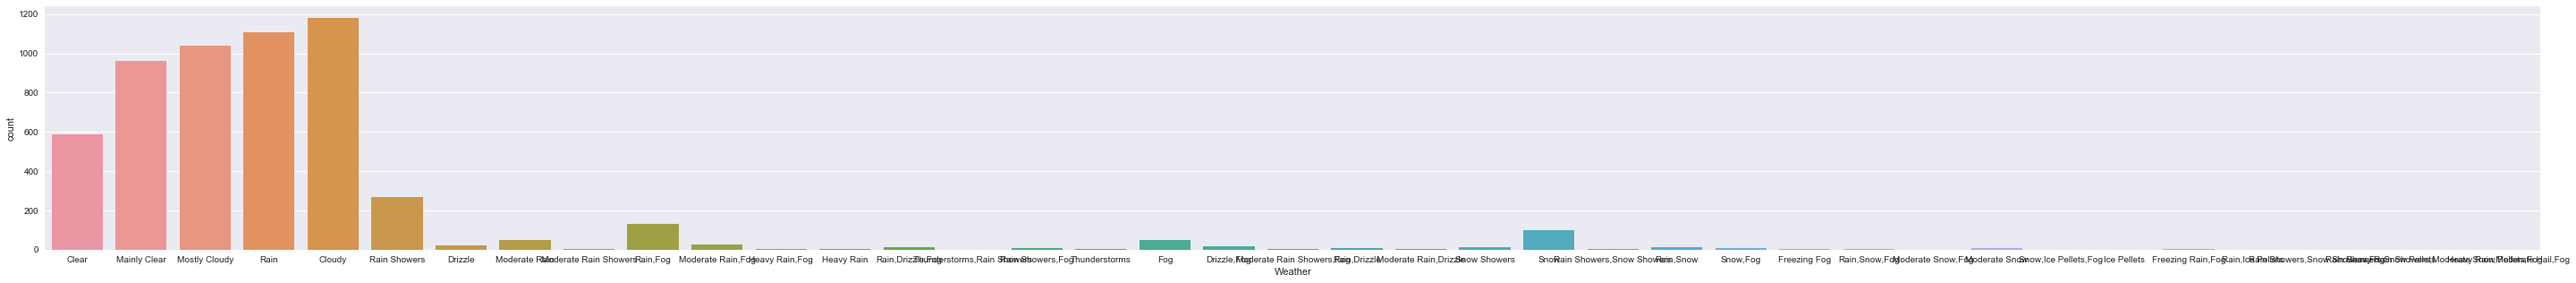

In [283]:
## shows unique weather category descritipion


weather_desc = pd.DataFrame(np.array(ndata['Weather'].unique()),columns=['WEATHER_DESC.'])
weather_desc
fig,ax = plt.subplots(figsize=(50,5))
x = sns.countplot(ax=ax,data=data,x=data['Weather'])
plt.savefig('plots/weather.jpg')

In [284]:
## FEATURE COMPARISON

def assign_colors(val) : 
    
    
    if val == 'Clear' : 
        color = 'pink'
    elif val == 'Mainly Clear' : 
        color = 'Orange'
    elif val == 'Mostly Cloudy' : 
        color = 'coral'
    elif val == 'Rain' : 
        color = 'Blue'
    elif val == 'Cloudy' : 
        color = 'dimgrey'
    elif val == 'Rain Showers' : 
        color = 'green'
    else : 
        color = 'gold'
    return color

ndata['color'] = ndata['Weather'].apply(assign_colors)
features = ndata[['Data Quality','Temp (°C)','Dew Point Temp (°C)','Rel Hum (%)','Wind Dir (10s deg)','Wind Spd (km/h)','Visibility (km)','Stn Press (kPa)']]


In [285]:
## FEATURE-ENGINEERING : CREATING 8 NEW FIELDS TO IDENTIFY DESCRIPTIONS SIMENTANEOUSLY
## Thunderstorms,drizzle are identified as rain category



def is_rain(val) : 
    REGEX1 = '^.*Rain.*$'
    REGEX2 = '^.*Drizzle.*$'
    REGEX3 = '^.*Thunderstorms.*$'
    if re.match(REGEX1,str(val)) is not None or re.match(REGEX2,str(val)) is not None or re.match(REGEX3,str(val)) is not None   : 
       
        return 1 
    else : 
        return 0
    
def is_clear(val) : 
    if re.match('^.*Clear.*$',str(val) )is not None : 
        return 1 
    else : 
        return 0

def is_snow(val) :
    if re.match('^.*Snow.*$',str(val) )is not None : 
        return 1 
    else : 
        return 0

def is_fog(val) : 
    if re.match('^.*Fog.*$',str(val) )is not None : 
        return 1 
    else : 
        return 0
    
def is_cloudy(val) : 
    if re.match('^.*Cloudy.*$',str(val) )is not None : 
        return 1 
    else : 
        return 0
    
    
def is_pellets(val) : 
    if re.match('^.*Pellets.*$',str(val) ) is not None : 
        return 1 
    else : 
        return 0

def new_weather_label(val) : 
    
    
    if val.is_pellets == 1 : 
        return 'Pellets'
    elif val.is_clear == 1 : 
        return 'Clear'
    elif val.is_rain == 1 : 
        return 'Rain'
    elif val.is_cloudy == 1 : 
        return 'Cloudy'
    elif val.is_fog == 1 : 
        return 'Fog'
    else : 
        return 'Unknown'
    


ndata['is_clear'] = ndata['Weather'].apply(is_clear)
ndata['is_snow'] = ndata['Weather'].apply(is_snow)
ndata['is_fog'] = ndata['Weather'].apply(is_fog)
ndata['is_cloudy'] = ndata['Weather'].apply(is_cloudy)
ndata['is_pellets'] = ndata['Weather'].apply(is_pellets)

ndata['is_rain'] = ndata['Weather'].apply(is_rain)


ldata = ndata[ndata['Weather'].isnull() == 0]
udata = ndata[ndata['Weather'].isnull() == 1]

ldata['new_weather'] = ldata.apply(new_weather_label,axis=1)
ldata['new_weather'].value_counts()


Cloudy     2220
Rain       1699
Clear      1548
Unknown     119
Fog          62
Pellets       5
Name: new_weather, dtype: int64

In [286]:
## CRIME DATA

filename = 'crime_csv_all_years.csv'
cdata = pd.read_csv(filename)

years = ['2016','2017']

def year_specific(val) : 
    val = str(val)
    if val in years : 
        return val
    else : 
        return np.nan

to_string = lambda x:str(x)

def crime_datetime(row) : 
    year = int(row['YEAR'])
    month = int(row['MONTH'])
    day = int(row['DAY'])
    hour = int(row['HOUR'])
    return datetime.datetime(year,month,day,hour,0,0)


## only data from 2016 and 2015
cdata['YEAR'] = cdata['YEAR'].apply(to_string)
cdata['YEAR'] = cdata['YEAR'].apply(year_specific)
cdata = cdata.dropna(axis=0,how='any')

## Adding the timestamp
cdata['date/time'] = cdata.apply(crime_datetime,axis=1)
cdata['timestamp'] = cdata['date/time'].values.astype(np.int64)

In [287]:
joined_data = ldata.merge(cdata,on='timestamp')
joined_features = ['Date/Time','Temp (°C)','Dew Point Temp (°C)','Rel Hum (%)','Wind Dir (10s deg)','Wind Spd (km/h)','Visibility (km)','TYPE']
joined_data = joined_data[joined_features]




## multiple crimes are happening in the same time. So, we need to find a way to aggregate it. 

In [288]:
## image data 

def image_datetime(row) :
    year = int(row['year'])
    month = int(row['month'])
    day = int(row['day'])
    hour = int(row['hour'])
 
    return datetime.datetime(year,month,day,hour,0,0)


IMAGE_DIR = 'image_data/katkam-scaled'

contents = os.listdir(IMAGE_DIR)
filenames = pd.DataFrame(contents,columns=['title'])


filenames['year'] = filenames['title'].str.extract('katkam-([0-9]{4}).*\.jpg')
filenames['month'] = filenames['title'].str.extract('katkam-[0-9]{4}([0-9]{2}).*\.jpg')
filenames['day'] = filenames['title'].str.extract('katkam-[0-9]{4}[0-9]{2}([0-9]{2}).*\.jpg')
filenames['hour'] = filenames['title'].str.extract('katkam-[0-9]{4}[0-9]{2}[0-9]{2}([0-9]{2}).*\.jpg')

filenames['timestamp'] = filenames.apply(image_datetime,axis=1)
filenames['title'].count()

6991

In [289]:
## compiling sun_present and average color data

sun_present_file = 'image_data/SUN_PRESENT.csv'
sun_present = pd.read_csv(sun_present_file,header=None)
sun_present.columns =['image_index','sun_present']

average_color_file = 'image_data/KATKAM_colors.csv'
average_color = pd.read_csv(average_color_file,header=None)
average_color.columns=['file_index','region_id','r','g','b']

sky_color = average_color[average_color['region_id']==1]
sky_color = sky_color[['file_index','r','g','b']]
sky_color = sky_color.reset_index()
sky_color.drop(['index'],axis=1)

filenames['sun_present'] = sun_present['sun_present']
filenames['sky_color_r'] = sky_color['r']
filenames['sky_color_g'] = sky_color['g']
filenames['sky_color_b'] = sky_color['b']


In [290]:
def to_hsv_red(row) : 
    r = row['sky_color_r']
    g = row['sky_color_g']
    b = row['sky_color_b']
    
    hsv = colorsys.rgb_to_hsv(r,g,b)
    return hsv[0]

def to_hsv_green(row) : 
    r = row['sky_color_r']
    g = row['sky_color_g']
    b = row['sky_color_b']
    
    hsv = colorsys.rgb_to_hsv(r,g,b)
    return hsv[1]

def to_hsv_blue(row) : 
    r = row['sky_color_r']
    g = row['sky_color_g']
    b = row['sky_color_b']
    
    hsv = colorsys.rgb_to_hsv(r,g,b)
    return hsv[2]

filenames['hsv_h'] = filenames.apply(to_hsv_red,axis=1)
filenames['hsv_s'] = filenames.apply(to_hsv_green,axis=1)
filenames['hsv_v'] = filenames.apply(to_hsv_blue,axis=1)


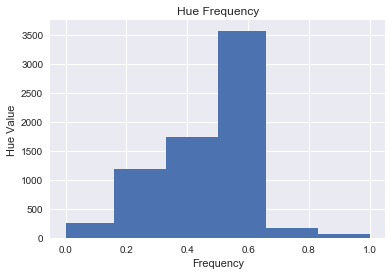

In [291]:
## hue frequence histogram
color_list = ['gold' if i==1 else 'blue' for i in filenames.loc[:,'sun_present']]

plt.title('Hue Frequency')
plt.hist(filenames['hsv_h'].values,bins=[0,0.16,0.33,0.5,0.66,0.83,1])
plt.xlabel('Frequency')
plt.ylabel('Hue Value')

## maximum hue is peak at bin 0.5 - 0.66 which is bluish color. 

In [ ]:
## This step is to see some relationship between huevalues and sun_present binary classification

## clutering
## {try doing clustering here ...}


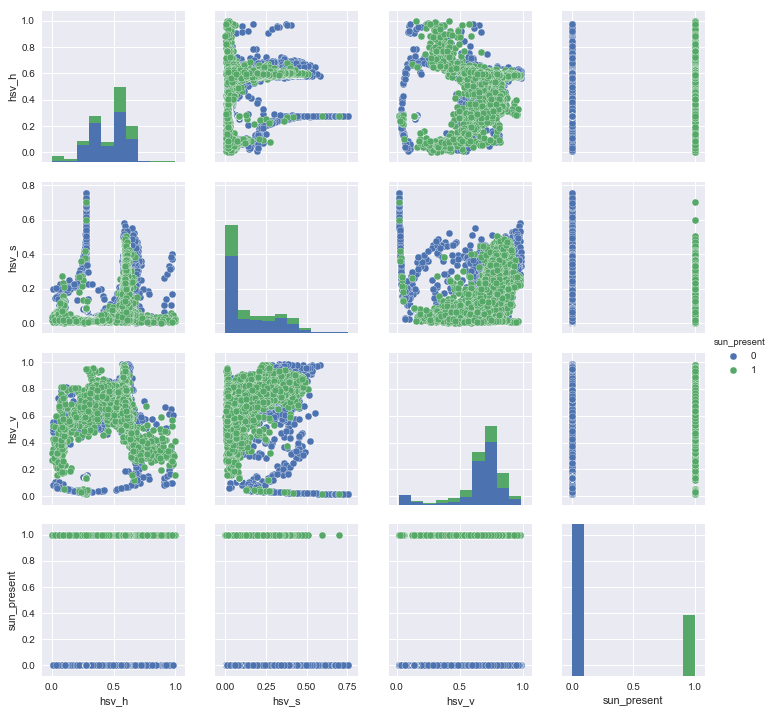

In [387]:
## COLOR AND SUN_PRESENT COMPARISON

filter_filnames = filenames[['hsv_h','hsv_s','hsv_v','sun_present']]
#pd.plotting.scatter_matrix(filter_filnames,figsize=(20,20))
#plt.title('HSV and sun_present comparison')
sns.pairplot(filter_filnames,hue='sun_present')

In [293]:
widata = ldata.merge(filenames,on='timestamp')


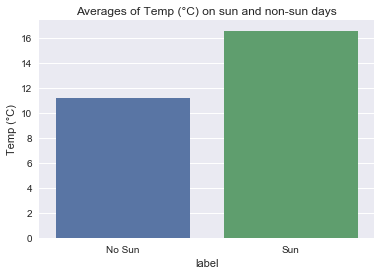

In [325]:
## lets look at average temperature when sun_present vs not sun_present

sun_and_temp = widata[['Temp (°C)','sun_present']]
sun_temp_avg = sun_and_temp.groupby('sun_present').agg(np.mean)
sun_temp_avg = sun_temp_avg.reset_index()
sun_temp_avg['label'] = ['No Sun','Sun'] 

#sns.countplot(x='sun_present',data=sun_and_temp)
sun_temp_avg = sun_temp_avg[['label','Temp (°C)']]
sns.barplot(x='label',y='Temp (°C)',data=sun_temp_avg).set_title('Averages of Temp (°C) on sun and non-sun days')

AttributeError: 'JointGrid' object has no attribute 'set_title'

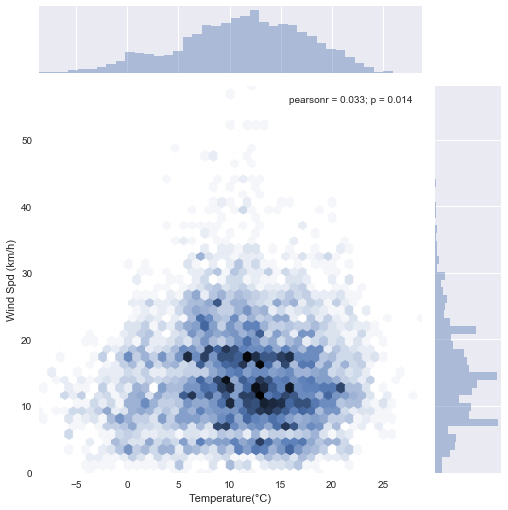

In [365]:
## RELATIONSHIP BETWEEN TEMPERATURE AND WIND DIRECTION

l = ldata[['Temp (°C)','Wind Spd (km/h)']]


ax = sns.jointplot(x=l['Temp (°C)'].values,y=l['Wind Spd (km/h)'].values,kind='hex',size=7)
ax.set_axis_labels('Temperature(°C)','Wind Spd (km/h)')
ax.set_title('asdf')

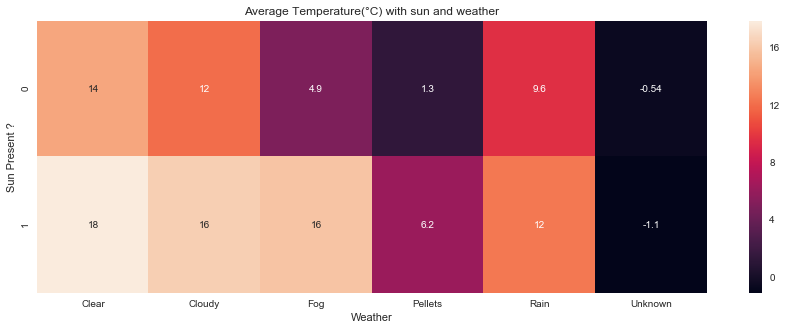

In [312]:
## HEATMAP OF TEMPERTURE, WEATHER AND SUN_PRESENT

ll = widata[['new_weather','sun_present','Temp (°C)']]

ll_pivot = ll.pivot_table(index='sun_present',columns='new_weather',values='Temp (°C)',aggfunc='mean')


hfig,hax = plt.subplots(figsize=(15,5))
sns.heatmap(ll_pivot,annot=True,ax=hax).set_title('Average Temperature(°C) with sun and weather')
plt.xlabel('Weather')
plt.ylabel('Sun Present ?')


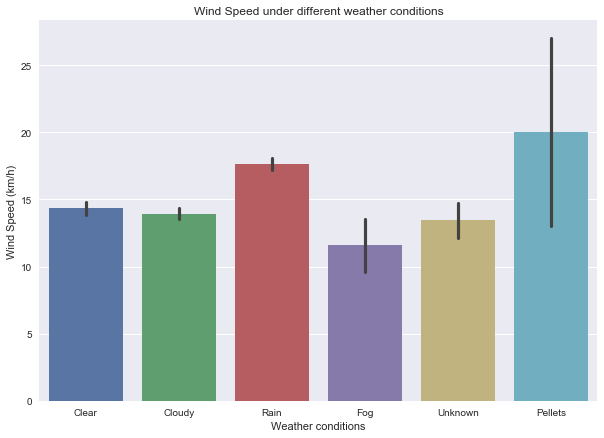

In [401]:
## wind speed and weather conditions

fig,ax = plt.subplots(figsize=(10,7))
sns.barplot(ax=ax,x='new_weather',y='Wind Spd (km/h)',data=widata)
ax.set_xlabel('Weather conditions')
ax.set_ylabel('Wind Speed (km/h)')
ax.set_title('Wind Speed under different weather conditions')

In [419]:
COLOUR_RGB = {
    'red': (255, 0, 0),
    'orange': (255, 114, 0),
    'yellow': (255, 255, 0),
    'green': (0, 230, 0),
    'blue': (0, 0, 255),
    'purple': (187, 0, 187),
    'brown': (117, 60, 0),
    'pink': (255, 187, 187),
    'black': (0, 0, 0),
    'grey': (150, 150, 150),
    'white': (255, 255, 255),
}
name_to_rgb = np.vectorize(COLOUR_RGB.get, otypes=[np.uint8, np.uint8, np.uint8])
name_to_rgb()

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'